# Projet Simulation Numérique ENSEEIHT 2021-2022
### Groupe: B2
### Nom: Hammi
### Prénom: Kamal

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 11/3/22 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement à distance**

Voici les informations concernant les séances (date, heure):

11/3/22 14.00-16.00 C/TD Groupes B1 et B2 (B306)

15/3/22 14.00-18.00 TP Groupe B1 (C306-C204)

18/3/22 08.00-12.00 TP Groupe B2 (C203)

25/3/22 14.00-16.00 TD Séance de réponse à vos questions éventuelles (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  20 avril 2022

**Contact**: xavier.vasseur@isae-supaero.fr

Merci d'indiquer [N7-PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A with column pivoting 
    Q, R ,P = qr(A,mode='economic',pivoting=True)
     
    
    # Deduce the T=R11^{-1}R12 block 
    R11 = R[range(k)][:,range(k)]
    R12 = R[range(k)][:,range(k,n)]
    T = solve_triangular(R11,R12)
    
    # Deduce J and Z 
    Z[:,P] = np.concatenate((np.eye(k),T),axis=1)
    J = P[range(k)]
    #
    # END TO DO   
    #
        
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A^T with column pivoting 
    Q, R ,P = qr(np.transpose(A),mode='economic',pivoting=True)
    
    
        
    # Deduce the corresponding T block 
    R11 = R[range(k)][:,range(k)]
    R12 = R[range(k)][:,range(k,m)]
    T = solve_triangular(R11,R12)
    
    
    # Deduce I and X 
    X[P,:] = np.transpose(np.concatenate((np.eye(k),T),axis=1))
    I = P[range(k)]
    
    
    #
    # END TO DO   
    #
        
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO   
    #
    
    # Apply the column ID to A
    J,Z = column_ID(A,k)
    
    
   
    # Apply the row ID to A[:,J]
    I,X = row_ID(A[:,J],k)
    
    #
    # END TO DO   
    #
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO   
    #
    
    # Apply the double sided interpolation algorithm 
    I,J,X,Z = double_sided_ID(A,k)
    
    
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]
      
    
    # Solve U R = Z in a least-squares sense
    U = np.dot(Z,np.linalg.pinv(R))
    #
    # END TO DO   
    #
    
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    
    #
    # TO DO   
    #
    
    # Apply the row ID algorithm to Y
    Y = np.dot(A,G)
    for i in range(q):
        Z = np.dot(np.transpose(A),Y)
        Y = np.dot(A,Z)
    I,X = row_ID(Y,k)
    #
    # END TO DO   
    #
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
      
    #
    # TO DO   
    #  
    
    # Apply the column ID algorithm to Y 
    Y = np.dot(G,A)
    for i in range(q):
        Z = np.dot(Y,np.transpose(A))
        Y = np.dot(Z,A)
    J,Z = column_ID(Y,k)
    
    # Apply the row ID algorithm to A[:,J]
    I,X = row_ID(A[:,J],k)
    
        
    # Deduce the CUR matrices (C, R and then U)
    C = A[:,J]
    R = A[I,:]
    U = np.dot(Z,np.linalg.pinv(R))

    #
    # END TO DO   
    #
    return I,J,C,U,R

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

(430, 1024)


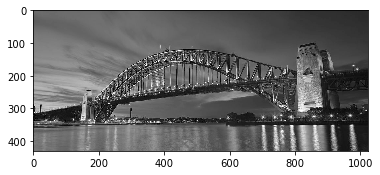

In [5]:
#
# Lecture de l'image parmi Golden_gate.jpg et Viaduc_de_Millau.jpg [couleur] 
#
#
imgc = Image.open("Sydney_harbour_bridge_dusk.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.13549375534057617
Estimated upper bound of the epsilon-rank:  240  for relative threshold:  0.05
Frobenius norm ratio:  0.043777952626985604  reached in  15 iterations
Time spent in the CUR algorithm 0.268535852432251
Time spent in the randomized CUR algorithm 0.26142287254333496
Time spent in the double sided ID algorithm 0.1482698917388916


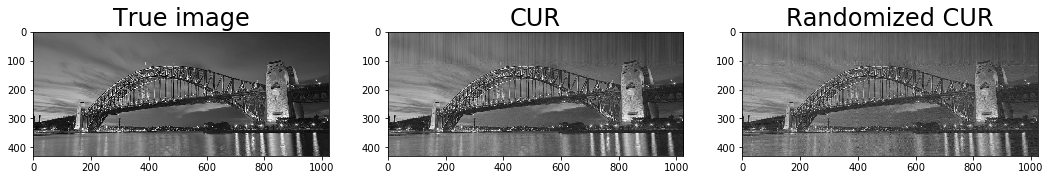

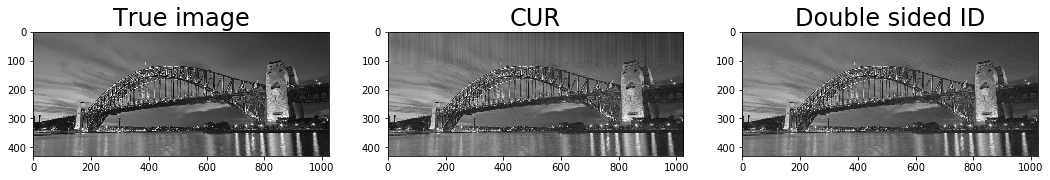

In [6]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID            = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

(1266, 2048)


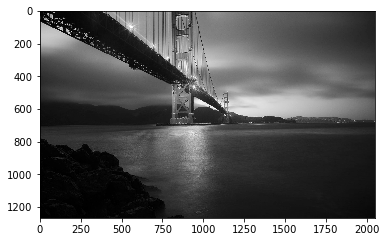

In [7]:
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Golden_gate.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.8911328315734863
Estimated upper bound of the epsilon-rank:  320  for relative threshold:  0.05
Frobenius norm ratio:  0.04872794148082216  reached in  20 iterations
Time spent in the CUR algorithm 1.084843635559082
(320, 2048)
Time spent in the randomized CUR algorithm 0.5199041366577148
(320, 2048)
Time spent in the double sided ID algorithm 0.8744776248931885
(320, 2048)


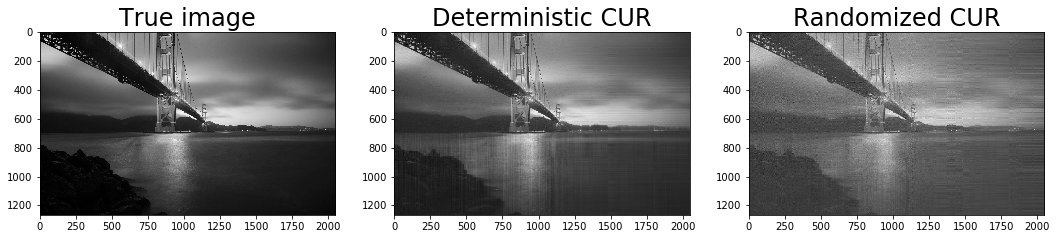

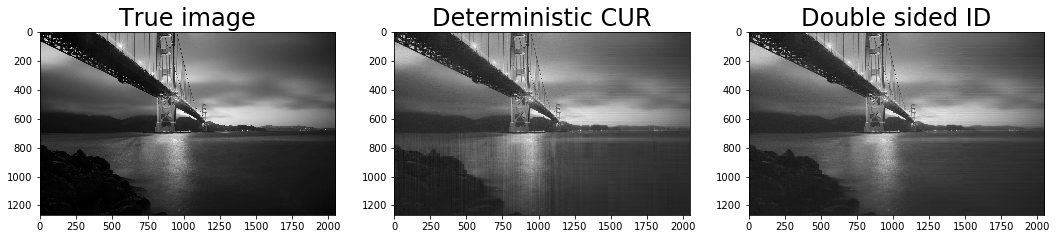

In [8]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID      = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Commentaires:**
Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

**Reponse:**
On remarque que la renconstruction de l'image par l'algorithme Deterministic CUR est moyennement bonne, au contarire de la renconstruction par l'algorithme Randomised CUR qui est plus mauvais, tandis que la renconstruction par l'algorithme Double sided ID est trés bonne que les autres. On ordonne ainsi les algorithmes par qualité croissante : Randomised CUR -> Deterministic CUR -> Double sided ID.

## Partie C.

En vous basant notamment sur les notes de cours, les chapitres 10 et 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe ID. 

**Réponse**: 
                 
         Parmi les avantages de la décomposition déterministe ID : 
* Si la matrice A est creuse ou non négatif, alors C l'est aussi.
* Elle nécessite moins de mémoire pour être stockée, au contraire de la décomposition QR ou SVD.
* La recherche des indices associés aux colonnes étendues est souvent utile pour l'interprétation des données.
* Dans le cadre des algorithmes numériques de discrétisation des EDP et des équations intégrales, l'ID souvent préserve "la physique" d'un problème tandis que le QR ou le SVD ne la préservent pas.

         Malgré ces avantages, l'ID a des inconvenients comme : 
* Si A n'est pas précisément de rang k, alors l'erreur d'approximation par l'ID du meilleur rang-k possible peut etre considérablement plus grand que l'erreur théoriquement minimale. il est exactement la même erreur minimale de la factorisation QR à colonne pivotée, puisque dans ce cas ces deux décompositions sont étroitement liées.
* L'ID est bien un algorithme qui est garanti pour trouver une factorisation conditionnée de manière optimale  de A, et donc il a une complexité combinatoire.
    

* C.2 Expliquer les raisons qui ont conduit à proposer des variantes aléatoires des algorithmes basés sur la décomposition déterministe ID. 

**Réponse**: L'ID fonctionne très bien pour les petites matrices, mais ça ne suffit pas pour des matrices qui sont clairsemés ou sont juste très grandes. Pour une matrice A trés grande, on calcule avec la méthode de la recherche aléatoire du rang (randomized rangefinder) la matrice Y qui est plus petite et dont les colonnes couvrent avec précision l'espace des colonnes de A, aprés on lui applique la méthode déterministe.

## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1). Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy. 

Time spent in the non-negative matrix factorization (NMF) 145.83717679977417
Norm ratio:  0.049994151646674  reached in  1191 iterations


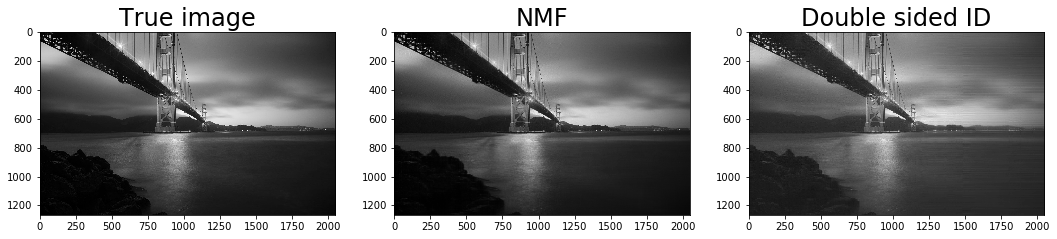

In [9]:
#
# Non-negative Matrix Factorization 
#
X = np.random.rand(m,erank) 
Y = np.random.rand(erank,n)

norm_A_Fro    = norm(M,'fro')
iteration     = 0
iteration_max = 1500
t_start       = time.time()

#
# NMF algorithm: TO DO
# M = XY ; V = WH 

for i in range(iteration_max):
    xtm = np.dot(np.transpose(X),M)
    xtx = np.dot(np.transpose(X),X)
    xtxy = np.dot(xtx,Y)
    Y = np.multiply(Y,np.divide(xtm,xtxy))
    
    my = np.dot(M,np.transpose(Y))
    xy = np.dot(X,Y)
    xyyt = np.dot(xy,np.transpose(Y))
    X = np.multiply(X,np.divide(my,xyyt))
    
    iteration = iteration +1
    if (norm(M-X@Y,'fro')/norm_A_Fro <= epsilon):
        break

    
    
#
# END TO DO   
#

print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm_A_Fro, " reached in ", iteration, "iterations") 

#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Commentaires:

Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite. Au final, comparer cette méthode avec les méthodes précédentes vues en Partie B.

**Réponse**: La vitesse de convergence de l'algorithme NMF est plus longue (en CPU, mais en GPU c'est bien trés rapide) que celle de l'algorithme Double sided ID, mais en revanche la qualité de renconstruction est beaucoup plus bonne.

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
